Code attribution:



*   https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/
*   https://github.com/prateekjoshi565/Fine-Tuning-BERT/blob/master/Fine_Tuning_BERT_for_Spam_Classification.ipynb



In [14]:
!pip install -U "tensorflow==2.8.*"
!pip install -U "tensorflow-text==2.8.*"
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s eta 0:00:00


In [41]:
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import transformers
from transformers import AutoModel, BertTokenizerFast
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# specify GPU
device = torch.device("cuda")

In [16]:
# load data
df = pd.read_csv('/content/Data/spam.csv')
df.head()

,Category,Message
0,not phishing,"Go until jurong point, crazy.. Available only ..."
1,not phishing,Ok lar... Joking wif u oni...
2,phishing,Free entry in 2 a wkly comp to win FA Cup fina...
3,not phishing,U dun say so early hor... U c already then say...
4,not phishing,"Nah I don't think he goes to usf, he lives aro..."


In [17]:
# check count and unique and top values and their frequency
df['Category'].value_counts()


not phishing    4825
phishing         747
Name: Category, dtype: int64

In [18]:
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [19]:
# creating 2 new dataframe as df_phishing, df_not_phishing

df_phishing = df[df['Category']=='phishing']

df_not_phishing = df[df['Category']=='not phishing']

print("Not Phishing Dataset Shape:", df_not_phishing.shape)

print("Phishing Dataset Shape:", df_phishing.shape)

Not Phishing Dataset Shape: (4825, 2)
Phishing Dataset Shape: (747, 2)


In [20]:
# downsampling not phishing dataset - take only random 747 example
# will use df_phishing.shape[0] - 747
df_nphishing_downsampled = df_not_phishing.sample(df_phishing.shape[0])
df_nphishing_downsampled.shape

(747, 2)

In [21]:
# concating both dataset - df_phishing and df_nphishing_downsampled to create df_balanced dataset
df_balanced = pd.concat([df_phishing , df_nphishing_downsampled])

df_balanced['Category'].value_counts()

phishing        747
not phishing    747
Name: Category, dtype: int64

In [22]:
df_balanced.sample(10)

,Category,Message
1638,phishing,"0A$NETWORKS allow companies to bill for SMS, s..."
1219,not phishing,K..k..i'm also fine:)when will you complete th...
1384,not phishing,Please reserve ticket on saturday eve from che...
5558,not phishing,"Sorry, I'll call later"
4864,phishing,Bored housewives! Chat n date now! 0871750.77....
4987,not phishing,That's y u haf 2 keep me busy...
389,phishing,4mths half price Orange line rental & latest c...
3646,phishing,wamma get laid?want real doggin locations sent...
1366,phishing,HOT LIVE FANTASIES call now 08707509020 Just 2...
4102,phishing,GSOH? Good with phishing the ladies?U could b ...


In [59]:
# creating numerical repersentation of category - one hot encoding
df_balanced['Type'] = df_balanced['Category'].apply(lambda x:1 if x=='phishing' else 0)

# displaying data - phishing -1 , not phishing-0
df_balanced.sample(4)

,Category,Message,phishing,Type
1993,phishing,Free tones Hope you enjoyed your new content. ...,1,1
3056,phishing,EASTENDERS TV Quiz. What FLOWER does DOT compa...,1,1
4477,not phishing,I'll pick you up at about 5.15pm to go to taun...,0,0
4624,not phishing,U need my presnts always bcz U cant mis love. ...,0,0


In [60]:
# loading train test split
X_train, temp_text , y_train, temp_labels = train_test_split(df_balanced['Message'], df_balanced['Type'],
                                                    stratify = df_balanced['Type'], test_size=0.3, random_state=2018)

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [61]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

<Axes: >

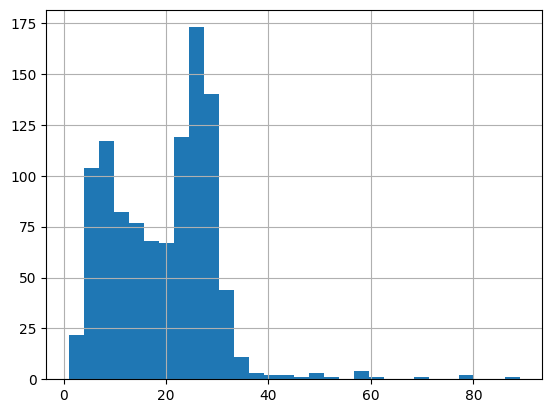

In [62]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in X_train]

pd.Series(seq_len).hist(bins = 30)


In [63]:
max_seq_len = 35

In [64]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    padding='max_length',
    truncation=True,
    return_token_type_ids=False
)

In [65]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
